# Principal Component Analysis Vs Exploratory Factor Analysis

###[Brian Feldstein](http://github.com/BrianFeldstein)

February 5, 2016

In this blog post we will discuss the similarities and differences between principal component analysis (PCA) and exploratory factor analysis (EFA).  These are both techniques which can be used to figure out which combinations of features are important to your data, and for reducing the dimensionality of your feature space.

## PCA

Suppose we have $p$ features, and $n$ data points, comprising an $n \times p$ matrix $X$.  Without loss of generality,
we may assume that the means for each feature have been subtracted (so that the columns of X each average to 0), and that each feature has also been normalized by its measured standard deviation (so that the standard deviation of each column is 1).

We can form the correlation matrix of X as 

$S = \frac{1}{n}X^T X$,

and determine its orthonormal eigenvectors $\overrightarrow{u}_1 .. \overrightarrow{u}_p$, and corresponding positive eigenvalues $d_1 .. d_n$.  These eigenvectors are referred to as "principal components".

We may then project the data onto a subspace spanned by some set of the $\overrightarrow{u}_i$'s with the largest eigenvalues.  The idea is that directions in feature space showing little variation in the data do not contain much useful information, and so can safely be dropped.

For example, let's consider a simple case in which we have two features, which are always equal to each other up to random, normally distributed measurement error terms:

$x_1 = a + e_1$

$x_2 = a + e_2$

Here the $e_i$'s are the error terms, and $a$ is some variable whose value determines the correlated parts of $x_1$ and $x_2$.
We can generate an example data set for this system, with 10,000 data points, as follows:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
%matplotlib inline

n = 10000
p = 2

a = np.random.normal(size=(n, 1))
e = np.random.normal(scale=0.2, size=(n, p))

X = np.hstack((a, a)) + e
X = X - np.mean(X, axis = 0)
X = X / np.std(X, axis = 0)

S = (1 / n) * np.transpose(X).dot(X)
eig = np.linalg.eig(S)
idx = eig[0].argsort()[::-1]   
u1 = eig[1][:, idx[0]]
u2 = eig[1][:, idx[1]]
d = eig[0][idx]
print(S)
print("Eigenvalues: ", d)
print("Eigenvector 1: ", u1)
print("Eigenvector 2: ", u2)

[[ 1.          0.96259933]
 [ 0.96259933  1.        ]]
Eigenvalues:  [ 1.96259933  0.03740067]
Eigenvector 1:  [ 0.70710678  0.70710678]
Eigenvector 2:  [-0.70710678  0.70710678]


Note that we have taken the error terms to have standard deviation $.2$, while a is normally distributed with standard deviation $1$.  Below we plot the data set and the two normalized eigenvectors:

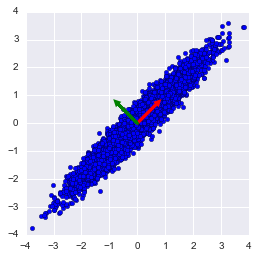

In [2]:
plt.scatter(X[:,0], X[:,1])
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.axes().set_aspect('equal')
ax = plt.axes()
ax.arrow(0, 0, u1[0], u1[1], head_width=0.1, head_length=0.1, lw=3, color='r')
ax.arrow(0, 0, u2[0], u2[1], head_width=0.1, head_length=0.1, lw=3, color='g')

We can see that $\overrightarrow{u}_2$, corresponding to the green arrow above, corresponds to a direction in which there is little variation in the data.  We could thus project the data onto the $\overrightarrow{u}_1$ (red) direction without losing too much information.

## Exploratory Factor Analysis

In EFA, one makes an *ansatz* that the features we measure in the data are linearly determined from a smaller set of more fundamental parameters, plus uncorrelated "measurement error" terms.  The data set we generated above for our PCA example happened to follow exactly this sort of ansatz, with 2 measured features $x_i$, and one underlying parameter $a$.

That is, in EFA, we take an ansatz

$x_i = \sum_{k} L_{ik} f_k + e_i$,

where the $f_k$'s are the fundamental underlying parameters, or "factors", and the "loadings" $L$ describe how the measured parameters are determined in terms of the $f_k$'s.  The $e_i$'s are the error terms.  Note that this form for the features is simply a model, and the data scientist looking at a data set has no a priori knowledge what the fundamental parameters are, or even how many there many be.

The goal of EFA is to try to determine what the fundamental parameters- or "factors"- underlying a data set might be. Let us assume there to be $m$ different factors in our model. We may assume that the $f_k$'s are uncorrelated with each other and have unit standard deviation (without loss of generality, since we may always redefine the $f_k$'s to have this property).  We also assume that the $f_k$'s and error terms are uncorrelated.  It then follows from our expression for the $x_i$'s above that if our ansatz is correct, the correlation matrix for the $x_i$'s in the full poulation will take the form

$P = L\ L^T + \psi$,

where $\psi = e\ e^T$ is diagonal since the measurement errors are assumed uncorrelated, and $L$ is a $p\times m$ matrix.

Given a measured data set X with $n$ data points, we may form the sample correlation matrix as $S = \frac{1}{n} X^T X$, and we may attempt to determine $L$ and $\psi$ so that our theoretical correlation matrix $P$ matches $S$ as closely as possible.
More precisely, we may try to minimize the sum of squares of all of the elements of $S-P$.  Note that the diagonal elements of $S-P$ may always be taken to $0$ by appropriately adjusting $\psi$.  Therefore, we would like to find a matrix $L$ such that the sum of squares of the off diagonal elements of $S - L\ L^T$ is as small as possible.

Note that if we can find such a matrix $L$, it is not unique.  We may always take a new matrix $L' = L\ O$ for any $m \times m$ orthogonal matrix O, and $L'\ L'^T$ will remain unchanged.  The columns of $L$ span a subspace of feature space corresponding to the directions of the factors in the model.  Applying an orthogonal transformation $O$ to $L$, simply corresponds to changing our basis for this factor subspace, in such a way that the underlying factors $f$ remain uncorrelated.

Let us consider again the same data set $X$ we generated above for our PCA example, but instead perform an exploratory factor analysis.  As shown above, our sample correlation matrix has the form

In [3]:
print("S = ")
print(pd.DataFrame(S).to_string(header=False, index=False))

S = 
 1.000000  0.962599
 0.962599  1.000000


With one factor, a candidate loading matrix is simply

In [4]:
print("L = ")
print(pd.DataFrame(np.array([["l1"],["l2"]])).to_string(header=False, index=False))

L = 
 l1
 l2


So that the off diagonal elements of $S$ may be approximated exactly by setting $l_1 = .962057/l_2$.

We thus see in this example, that one factor, pointing in any direction in feature space, could be thought of as "underlying" the data set (so long as the model also included appropriate measurement errors for the two measured variables in order to also reproduce the diagonal elements of $S$).  Of course, in this case the conclusion is correct: we did indeed generate the data set with a single underlying factor.

However, exactly the same mathematics shows that in fact, in factor analysis, a 2 dimensional feature space may *always* be represented exactly as coming from a single underlying factor.  This is in clear contrast to PCA, where, if we had set larger errors "e" in generating the data set, then the oval in our above figure would become more spread out and circular.  We would then have concluded that both principal components were needed to describe the data.  In EFA however, we would always find a perfect fit with one factor.

The present example also shows that exploratory factor analysis does not lead to unique factors.  When the number of model factors is much smaller than the number of measured features, typically only the orthogonal transformation ambiguity mentioned above is present (in which case the subspace spanned by the factors is fixed).  As in this 2 dimensional example case, however, there can also be further ambiguities.

Factor analysis tries to find a description of the data in terms of a smaller set of underlying factors, but there are in general many such possible descriptions.  What is typically done, is to look for a set of factors with further desirable properties, such as having loading matrices with many elements close to 0.  This sort of structure makes factors easier to "interpret" intuitively in terms of the measured variables.  Perhaps more importantly, if it is actually the case that some of the measured variables are more fundamental than (and determine) the others, it may be possible to use factor analysis to determine which ones they are by looking for the simplest factor structure.

# Comparing PCA and EFA

At this point one might be tempted to conclude that PCA and EFA are essentially unrelated, both in concept and output.

PCA tries to find a set of eigenvectors of the correlation matrix, in order to find directions in the data with the largest variance.  One can then reduce the dimensionality of the data set by projecting onto those eigenvectors with the largest eigenvalues.  In this way one reduces the effective size of the feature space without losing too much information. 

Factor Analysis begins with a different point of view; it tries to model correlations between measured variables in the data by writing them as linear combinations of some smaller set of underlying "factors".  EFA does not care about intrinsic variance in a measured variable due to measurement error, and therefore only tries to model the off-diagonal elements of the correlation matrix.

*However, mathematically, PCA and EFA have a lot more in common with each other than is immediately apparent.*

Let us arrange the $m$ PCA principal component eigenvectors with $m$ highest eigenvalues into the columns of a matrix $U$.  Let $D$ be the corresponding $m \times m$ matrix of eigenvalues.  We may define a loading matrix for PCA as $L = U\ D^{1/2}$.  If $m$ was set to its maximum value of $p$ then we would have $S = L\ L^T$.  For smaller $m$, we might wonder how well $L\ L^T$ actually approximates $S$... in fact it provides the best possible approximation to $S$ amongst all $L$'s of the given dimensions, as defined by the sum of squared errors of the matrix elements!  The proof follows quickly from the Eckart-Young theorem (see https://en.wikipedia.org/wiki/Singular_value_decomposition).

Therefore, $P = L\ L^T$ minimizes the sum of squared errors of the matrix $S - P$.  Notice the obvious similarity to factor analysis, where we tried to minimize the same quantity, but with $P = L\ L^T + \psi$ for $\psi$ diagonal.  Thus PCA provides a solution to the factor analysis problem, except that PCA does not ignore intrinsic measurement error on each measured variable in the same way that factor analysis does (and there is no need to assume uncorrelated measurement errors as in factor analysis).

In fact, the loading matrix provided by PCA becomes a better and better approximation to a factor analysis solution as the original number of features $p$ becomes large.  This is because there are $\frac{p^2 - p}{2}$ diagonal components of $S$, but only $p$ diagonal components.  Therefore, the fact that factor analysis solutions do not attempt to approximate the diagonal components of $S$ becomes less and less important for larger $p$.

Note that in PCA, the principal component eigenvectors and their eigenvalues may be solved for algebraically. Unfortunately, the same is not true for EFA: the loading matrices $L$ can only be determined numerically.  Moreover, in EFA, given the form of the model $x_i = \sum_{k} L_{ik} f_k + e_i$, and some set of factor loadings $L$ and a set of measurements $x_i$, there is in general no unique way to determine what the underlying factor scores $f_k$ were behind the measurements.  To estimate the $f_k$, various procedures may be adopted, such as choosing the $f_k$ which minimize the required measurement errors $e_i$.  The resulting factor scores may then be used as a "reduced" set of feature values if desired, just as PCA may be used for dimensionality reduction.


# Summary

Principal Component Analysis and Exploratory Factor analysis are both methods which may be used to reduce the dimensionality of data sets.  Philosophically they are very different: PCA tries to write all variables in terms of a smaller set of features which allows for a maximum amount of variance to be retained in the data.  EFA tries to find a set of features which allow for understanding as much of the *correlations* between measured variables as possible.  However, EFA does not attempt to reproduce variance which is due to "measurement error" only affecting measured variables individually.  

In PCA the principal component directions are taken to be eigenvectors of the correlation matrix, while an analogous requirement is not used in EFA.  In EFA one rather tries to find a set of underlying features which is related in a simple way to the original measured variables, although there is generally not a unique solution.  Mathematically, a set of principle components from PCA will give an approximate solution for the EFA problem when the number of measured variables is large.